<a href="https://colab.research.google.com/github/alimoorreza/CS167-sp25-notes/blob/main/Day25_CNN_finetuning_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS167: Day25
## Fine-tuning Convolutional Neural Network (CNN)

#### CS167: Machine Learning, Spring 2025


📜 [Syllabus](https://analytics.drake.edu/~reza/teaching/cs167_sp25/cs167_syllabus_sp25.pdf)


## __Put the Model on Training Device (GPU or CPU)__
We want to accelerate the training process using graphical processing unit (GPU). Fortunately, in Colab we can access for GPU. You need to enable it from _Runtime-->Change runtime type-->GPU or TPU_

In [ ]:
# check to see if torch.cuda is available, otherwise it will use CPU
import torch
import torch.nn as nn
import numpy as np
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


#__Download the Dataset for AlexNet__

- [Bike-Cat-Dog-Person Dataset](https://analytics.drake.edu/~reza/teaching/cs167_fall24/dataset/bcdp_v1.zip)
  - also available on Blackboard under the dataset directory
  - Each image size: __100x100x3__
    - Note that these are color images
  - Each image is associated with a label from __4 classes__
  - Training set of __1500__ examples and test set of __300__ examples



#__Prepare Your Data for Training__


In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms


# For fine-tuning with an AlexNet/VGG/ResNet architecture that has been pre-trained using the ImageNet dataset, you need to normalize
# each image with the given mean and standard deviation.
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((.229, .224, .225), (.485, .456, .406)) # ImageNet: mean (R, G, B) and standard deviation (R, G, B)
])


train_dir       = '/kaggle/input/bcdp-v1/bcdp_v1/train' #/content/drive/MyDrive/cs167_sp25/datasets/bcdp_v1/train'
test_dir        = '/kaggle/input/bcdp-v1/bcdp_v1/test'

train_dataset   = datasets.ImageFolder(train_dir, transform=transform)
test_dataset    = datasets.ImageFolder(test_dir,  transform=transform)

N_train         = len(train_dataset)
N_test          = len(test_dataset)

number_of_classes = 4

print("Size of train set:", N_train)
print("Size of test set:",  N_test)

Size of train set: 1500
Size of test set: 300


#__Building Convolutional Neural Network (CNN)__

Create a network class with two methods:
- _init()_
- _forward()_


In [ ]:
import torch
import torch.nn as nn
from torchvision import models
import pdb

# You can give any name to your new network, e.g., AlexNet.
# You should load the pretrained AlexNet model from torchvision.models.
# This model was trained on over a million real-world images from ImageNet.
# The idea is to bootstrap our CNN network weights with pretrained weights.
# Our model will converge to a solution faster.
# This training process is called 'fine-tuning.'


class AlexNet(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(AlexNet, self).__init__()
        net = models.alexnet(pretrained=True)

        # retained earlier convolutional and pooling layers from AlexNet
        self.features   = net.features
        self.avgpool    = net.avgpool

        # added new fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )


    def forward(self, x):
        #print("shape of input: ", x.shape)
        x = self.features(x)
        #print("output shape (self.features): ", x.shape)
        x = self.avgpool(x)
        #print("output shape (self.avgpool): ", x.shape)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        #print("output shape (self.classifier): ", x.shape)
        return x



In [ ]:
# check the structure of AlexNet

cnn_model = AlexNet(number_of_classes)
cnn_model.to(device)
print(cnn_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 112MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dro

##__Defining Loss function__

- [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss)
  - useful when training a __classification problem__ with __C__ classes.
  - criterion computes the cross entropy loss between input logits and target

In [ ]:
# initialize the loss function
loss_fn = nn.CrossEntropyLoss() # this is useful for multiclass classification task

##__Initializing the Optimizer__

Optimiztaion, as we have discussed in previous week, is process of adjusting model parameters to reduce model error in each training step. PyTorch provides a selection of optimization algorithms in the [torch.optim](https://pytorch.org/docs/stable/optim.html) package. Some of them are as follows:
- [torch.optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)
- [torch.optim..Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
- [torch.optim.RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)

In addition to selecting the optimizer, we can also select the yperparameters which are refered to as adjustable parameters crucial for controlling the model optimization process. You can influence the training and convergence of the model by tweaking these hyperparameters:
- __epochs:__ denotes the number of iterations over the dataset
- __batch size:__ represents the quantity of data samples in each iteration propagated through the network before updating the parameters
- __learning rate:__ determines the extent of parameter updates made at each batch/epoch



In [ ]:
learning_rate = 1e-4
batch_size    = 32
epochs        = 20
# let's use ADAM optimization algorithm for training our model
optimizer     = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)

#__Putting Everything Together for AlexNet__

__Putting Everything Together using our AlexNet Network on our 4-class image recognition Dataset__


Using cuda device
Size of train set: 1500
Size of test set: 300


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 219MB/s] 


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dro

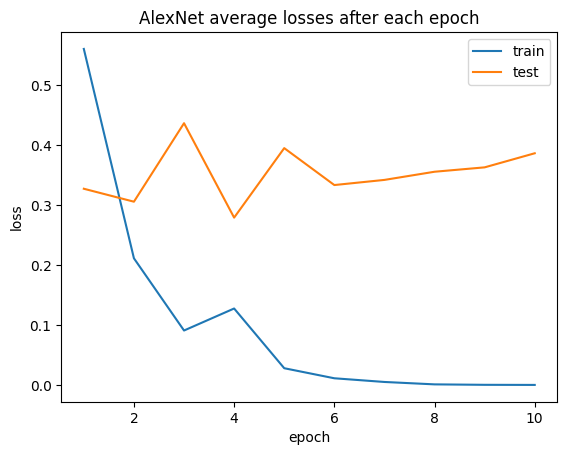

In [ ]:
# Step 1: load the Torch library and other utilities
#----------------------------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import transforms, datasets
from torchvision import models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas
import time
import numpy as np
import os
import pdb

# check to see if torch.cuda is available, otherwise it will use CPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

# os.environ["CUDA_VISIBLE_DEVICES"]="0"
# Step 2: load the dataset
#--------------------------------------------------------------------------------------------------
# For fine-tuning with an AlexNet/VGG/ResNet architecture that has been pre-trained using the ImageNet dataset, you need to normalize
# each image with the given mean and standard deviation.
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((.229, .224, .225), (.485, .456, .406)) # ImageNet: mean (R, G, B) and standard deviation (R, G, B)
])


train_dir       = '/kaggle/input/bcdp-v1/bcdp_v1/train'
test_dir        = '/kaggle/input/bcdp-v1/bcdp_v1/test'

train_dataset   = datasets.ImageFolder(train_dir, transform=transform) # it loads images from the given directory, subsequently, classes are assigned labels according to the sorted order of the folder names.
test_dataset    = datasets.ImageFolder(test_dir,  transform=transform) # it loads images from the given directory, subsequently, classes are assigned labels according to the sorted order of the folder names.

N_train         = len(train_dataset)
N_test          = len(test_dataset)

number_of_classes = 4                    # Headsup! You should change this to the appropriate number when you fine-tune your model on a different dataset.

print("Size of train set:", N_train)
print("Size of test set:",  N_test)


# Step 3: Use the AlexNet from above
#--------------------------------------------------------------------------------------------------

# You can give any name to your new network, e.g., AlexNet.
# You should load the pretrained AlexNet model from torchvision.models.
# This model was trained on over a million real-world images from ImageNet.
# The idea is to bootstrap our CNN network weights with pretrained weights.
# Our model will converge to a solution faster.
# This training process is called 'fine-tuning.'


class AlexNet(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(AlexNet, self).__init__()
        net = models.alexnet(pretrained=True)

        # retained earlier convolutional and pooling layers from AlexNet
        self.features   = net.features
        self.avgpool    = net.avgpool

        # added new fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )


    def forward(self, x):
        #print("shape of input: ", x.shape)
        x = self.features(x)
        #print("output shape (self.features): ", x.shape)
        x = self.avgpool(x)
        #print("output shape (self.avgpool): ", x.shape)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        #print("output shape (self.classifier): ", x.shape)
        return x


# Step 4: Your training and testing functions
#--------------------------------------------------------------------------------------

def train_loop(dataloader, model, loss_fn, optimizer):

    size            = len(dataloader.dataset)
    num_batches     = len(dataloader)

    model.train()                   # set the model to training mode for best practices

    train_loss      = 0
    correct         = 0
    train_pred_all  = []
    train_y_all     = []

    for batch, (X, y) in enumerate(dataloader):
        # compute prediction and loss

        # ----------- putting data into gpu or sticking to cpu ----------
        X = X.to(device)     # send data to the GPU device (if available)
        y = y.to(device)
        # -----------                                         ----------

        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        # compute the accuracy
        pred_prob   = softmax(pred)
        pred_y 			= torch.max(pred_prob, 1)[1]
        train_correct = (pred_y == y).sum()
        correct    += train_correct.data

        train_pred_all.append(pred_y) # save predicted output for the current batch
        train_y_all.append(y)         # save ground truth for the current batch

    #pdb.set_trace()
    train_pred_all = torch.cat(train_pred_all) # need to concatenate batch-wise appended items
    train_y_all = torch.cat(train_y_all)

    train_loss = train_loss/num_batches
    correct    = correct.cpu().numpy()/size

    print('Confusion matrix for training set:\n', confusion_matrix(train_y_all.cpu().data, train_pred_all.cpu().data))
    return train_loss, 100*correct


def test_loop(dataloader, model, loss_fn):

    model.eval()                    # set the model to evaluation mode for best practices

    size                = len(dataloader.dataset)
    num_batches         = len(dataloader)
    test_loss, correct  = 0, 0
    test_pred_all       = []
    test_y_all          = []

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():

      for X, y in dataloader:

        # ----------- putting data into gpu or sticking to cpu ----------
        X = X.to(device)     # send data to the GPU device (if available)
        y = y.to(device)
        # -----------                                         ----------

        pred = model(X)
        test_loss += loss_fn(pred, y).item()

        # calculate probability and save the outputs for confusion matrix computation
        pred_prob     = softmax(pred)
        pred_y        = torch.max(pred_prob, 1)[1]
        test_correct  = (pred_y == y).sum()
        correct      += test_correct.data

        test_pred_all.append(pred_y) # save predicted output for the current batch
        test_y_all.append(y)         # save ground truth for the current batch


    #pdb.set_trace()
    test_pred_all = torch.cat(test_pred_all)
    test_y_all = torch.cat(test_y_all)

    test_loss = test_loss/num_batches
    correct   = correct.cpu().numpy()/size
    print(f"Test Performance: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print('Confusion matrix for test set:\n', confusion_matrix(test_y_all.cpu().data, test_pred_all.cpu().data))
    return test_loss, 100*correct, confusion_matrix(test_y_all.cpu().data, test_pred_all.cpu().data)

# Step 5: prepare the DataLoader and select your optimizer and set the hyper-parameters for learning the model from DataLoader
#------------------------------------------------------------------------------------------------------------------------------

cnn_model = AlexNet(number_of_classes)
cnn_model.to(device)
print(cnn_model)


learning_rate     = 1e-4
batch_size_val    = 32
epochs            = 10
loss_fn           = nn.CrossEntropyLoss()
optimizer         = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)
softmax           = nn.Softmax(dim=1) # for calculating the probability of the network prediction. It is used in train_loop() and test_loop().

train_dataloader  = DataLoader(train_dataset, batch_size=batch_size_val, shuffle=True)  # shuffle the images in training set during fine-tuning
test_dataloader   = DataLoader(test_dataset, batch_size=batch_size_val,  shuffle=False) # you don't need to shuffle test images as they are not used during training


train_losses = []
test_losses  = []
train_accuracies = []
test_accuracies = []
start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_train_loss, train_accuracy                    = train_loop(train_dataloader, cnn_model, loss_fn, optimizer)
    avg_test_loss, test_accuracy, conf_matrix_test    = test_loop(test_dataloader,   cnn_model, loss_fn)
    # save the losses and accuracies
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

print("AlexNet model has been fine-tuned!")
print("Total fine-tuning time: %.3f sec" %( (time.time()-start_time)) )
print("Total fine-tuning time: %.3f hrs" %( (time.time()-start_time)/3600) )

# visualizing the loss curves
plt.plot(range(1,epochs+1), train_losses)
plt.plot(range(1,epochs+1), test_losses)
plt.title('AlexNet average losses after each epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()


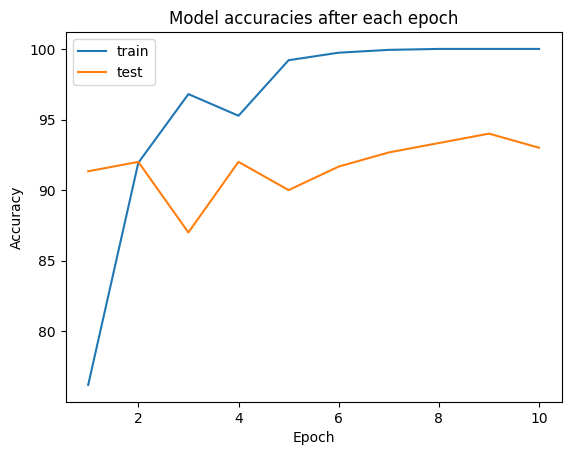

In [ ]:
# visualizing the accuracy curves

plt.plot(range(1,epochs+1), train_accuracies)
plt.plot(range(1,epochs+1), test_accuracies)
plt.title('Model accuracies after each epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.show()


        bike  cat  dog  person
bike      43    0    0       7
cat        0   97    3       0
dog        1    4   95       0
person     0    3    3      44


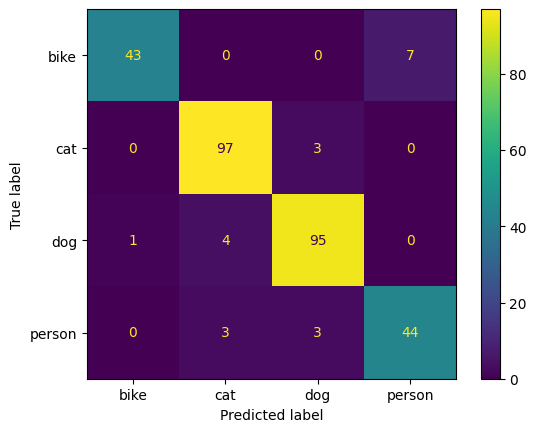

In [ ]:
# visualizing the confusion matrix on the test set after the final epoch
dataset_labels = ['bike', 'cat', 'dog', 'person'] # datasets.ImageFolder(): assigns labels according to the sorted order of the folder names

# option #1: text
print(pandas.DataFrame(conf_matrix_test, index = dataset_labels, columns = dataset_labels))

# option #2: prettify
displ = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=dataset_labels)
displ.plot()
plt.show()

#__Group Exercise__:
Use AlexNet and then fine-tune that model on the given dataset of images. Make the necessary changes to the above-given code.
- [Bike-Cat-Dog-Flower-Horse Dataset](https://analytics.drake.edu/~reza/teaching/cs167_fall24/dataset/bcdfh_v1.zip)

In [ ]:
# Step 1: load the Torch library and other utilities
#----------------------------------------------------



In [ ]:
# Step 2: load the dataset
#--------------------------------------------------------------------------------------------------


In [ ]:
# Step 3: Use the AlexNet from above
#--------------------------------------------------------------------------------------------------


In [ ]:
# Step 4: Your training and testing functions
#--------------------------------------------------------------------------------------


In [ ]:
## Step 5: select your optimizer and set the hyper-parameters for learning the model
#------------------------------------------------------------------------------------------------------------------------------
